# References
* https://github.com/manicman1999/GAN256
* https://github.com/t0nberryking/DCGAN256
* https://www.tensorflow.org/tutorials/generative/dcgan
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://keras.io/examples/generative/wgan_gp/

# Imports

In [61]:
import os
import time

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing

# Load Dataset

In [69]:
batch_size = 256
img_dim = 128
channels = 3
img_shape = (img_dim, img_dim, channels)

dataset = preprocessing.image_dataset_from_directory(
  'C:/Users/8psco/Desktop/ancient_coins/greek_coins',
  image_size=(img_dim, img_dim),
  batch_size=batch_size,
  interpolation='area',
  validation_split=0.25,
  subset='validation',
  seed=1234,
)
dataset = dataset.map(lambda x, _: (x - 127.5) / 127.5)

Found 42703 files belonging to 1 classes.
Using 10675 files for validation.


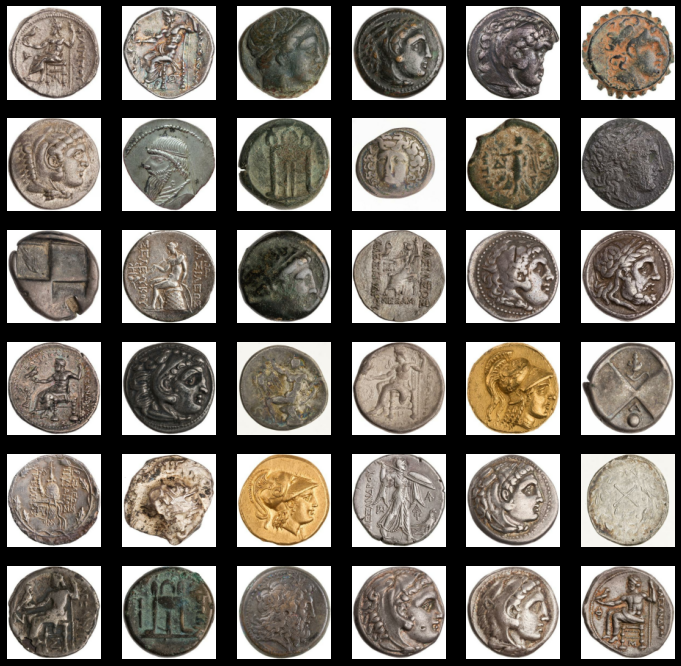

In [70]:
num_examples = 36

fig = plt.figure(figsize=(12, 12))
X = dataset.as_numpy_iterator().next()
for i in range(min(len(X), num_examples)):
  grid_size = int(np.sqrt(num_examples))
  fig.add_subplot(grid_size, grid_size, i + 1)
  plt.imshow(X[i] * 0.5 + 0.5)
  plt.axis('off')

# Create WGAN-GP

Create generator

In [71]:
noise_dim = 128

generator = models.Sequential([
  layers.Reshape(target_shape=(1, 1, noise_dim), input_shape=(noise_dim,)),

  # 1x1x128
  layers.Conv2DTranspose(filters=512, kernel_size=4, strides=1, use_bias=False),
  layers.BatchNormalization(),
  layers.ReLU(),

  # 4x4x512
  layers.Conv2DTranspose(filters=256, kernel_size=5, strides=2, use_bias=False, padding='same'),
  layers.BatchNormalization(),
  layers.ReLU(),

  # 8x8x256
  layers.Conv2DTranspose(filters=128, kernel_size=5, strides=2, use_bias=False, padding='same'),
  layers.BatchNormalization(),
  layers.ReLU(),

  # 16x16x128
  layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, use_bias=False, padding='same'),
  layers.BatchNormalization(),
  layers.ReLU(),

  # 32x32x64
  layers.Conv2DTranspose(filters=32, kernel_size=5, strides=2, use_bias=False, padding='same'),
  layers.BatchNormalization(),
  layers.ReLU(),

  # 64x64x32
  layers.Conv2DTranspose(filters=channels, kernel_size=5, strides=2, use_bias=False, padding='same', activation='tanh'),
])
generator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 4, 4, 512)         1048576   
_________________________________________________________________
batch_normalization_39 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu_24 (ReLU)              (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_40 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
re_lu_25 (ReLU)              (None, 8, 8, 256)        

Create critic (similar to discriminator in DCGANs)

In [72]:
critic = models.Sequential([
  # 128x128x3
  layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', use_bias=False, input_shape=img_shape),
  layers.LeakyReLU(alpha=0.2),

  # 64x64x32
  layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(alpha=0.2),

  # 32x32x64
  layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(alpha=0.2),

  # 16x16x128
  layers.Conv2D(filters=256, kernel_size=5, strides=2, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(alpha=0.2),

  # 8x8x256
  layers.Conv2D(filters=512, kernel_size=5, strides=2, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(alpha=0.2),

  # 4x4x512
  layers.Flatten(),
  layers.Dense(1)
])
critic.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 32)        2400      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        51200     
_________________________________________________________________
batch_normalization_44 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 128)       204800    
_________________________________________________________________
batch_normalization_45 (Batc (None, 16, 16, 128)     

# Training

Wasserstein Gradient Penalty Loss (Critic and Generator Losses)

$L_C=\mathbb{E}[C(G(z))]-\mathbb{E}[C(x)]+\lambda\mathbb{E}[(||\nabla C(i)||_2-1)^2]$

$L_G=-\mathbb{E}[C(G(z))]$

Where

* $C$ is the critic

* $G$ is the generator

* $x$ is sampled from the distribution of real images

* $z$ is random noise such that $z\sim\mathcal{N}(0,1)$

* $i$ is an interpolation between real and fake images defined as $i=\alpha x-(1-\alpha)G(z)$ where $\alpha\sim\mathcal{U}(0,1)$

* $C(x)$ is the critic's score for an input real image $x$

* $G(z)$ is an image generated using noise $z$

* $C(G(z))$ is the critic's score for an input fake image $G(z)$

* $\lambda$ is the penalty amount hyperparameter (the code uses $\lambda=10$)

Loss Explanations

* The critic is trying to minimize $L_C$, which is equivalent to maximizing $\mathbb{E}[C(x)]$ and minimizing $\mathbb{E}[C(G(z))]$. The critic is trying to give the real images higher scores than the fake images.

* The generator is trying to minimize $L_G$ (which is equivalent to maximizing $\mathbb{E}[C(G(z))]$). The generator is trying to trick the critic into giving fake images high scores.

* A penalty $\lambda\mathbb{E}[(||\nabla C(i)||_2-1)^2]$ is added to the critic loss to prevent the gradient of the critic from growing too large.

In [73]:
num_examples = 36 # number of generated images to show each epoch

generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.9)
critic_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.9)
seed = tf.random.normal([num_examples, noise_dim])

dataset_name = 'greek_coins'
checkpoint_dir = f'checkpoints/{dataset_name}'
output_dir = f'output_images/{dataset_name}'
losses_dir = f'losses/{dataset_name}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
  generator_optimizer=generator_optimizer,
  critic_optimizer=critic_optimizer,
  generator=generator,
  critic=critic,
)

def train(dataset, epochs, restore_epoch=0, generator_losses=[], critic_losses=[], save_freq=20):
  mkdir('seeds')
  np.save(f'seeds/{dataset_name}_seed.npy', seed)

  avg_time_per_epoch = 0
  for epoch in range(restore_epoch, epochs):
    start = time.time()

    for image_batch in dataset:
      critic_loss = train_critic(image_batch)
      generator_loss = train_generator(len(image_batch))

    generator_losses.append(generator_loss)
    critic_losses.append(critic_loss)

    mkdir(losses_dir)
    np.save(f'{losses_dir}/generator_losses.npy', generator_losses)
    np.save(f'{losses_dir}/critic_losses.npy', critic_losses)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)
    print(f'Generator Loss: {round(float(generator_loss), 3)} | Critic Loss: {round(float(critic_loss), 3)}')

    if (epoch + 1) % save_freq == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    avg_time_per_epoch = print_time(start, epoch, epochs, avg_time_per_epoch)
  return generator_losses, critic_losses


def train_critic(real_images):
  noise = tf.random.normal([len(real_images), noise_dim]) # z
  with tf.GradientTape() as critic_tape:
    fake_images = generator(noise, training=True) # G(z)

    real_output = critic(real_images, training=True) # C(x)
    fake_output = critic(fake_images, training=True) # C(G(z))
    
    critic_loss_unpenalized = get_critic_loss(real_output, fake_output) # E[C(G(z))] - E[C(x)]
    penalty = get_gradient_penalty(real_images, fake_images) # E[(||∇C(i)||₂ - 1)²]
    critic_loss = critic_loss_unpenalized + 10.0 * penalty # E[C(G(z))] - E[C(x)] + λ * E[(||∇C(i)||₂ - 1)²]

  gradients_of_critic = critic_tape.gradient(critic_loss, critic.trainable_variables)
  critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
  return critic_loss


def train_generator(batch_size):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as generator_tape:
    fake_images = generator(noise, training=True) # G(z)
    fake_output = critic(fake_images, training=True) # C(G(z))
    generator_loss = get_generator_loss(fake_output) # -E[C(G(z))]

  gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  return generator_loss


# E[C(G(z))] - E[C(x)]
def get_critic_loss(real_output, fake_output):
  return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)


# -E[C(G(z))]
def get_generator_loss(fake_output):
  return -tf.reduce_mean(fake_output)


# E[(||∇C(i)||₂ - 1)²]
def get_gradient_penalty(real_images, fake_images):
  alpha = tf.random.normal((len(real_images), 1, 1, 1))
  interpolated = alpha * real_images + (1 - alpha) * fake_images # i = α * x + (1 - α) * G(z)

  with tf.GradientTape() as penalty_tape:
    penalty_tape.watch(interpolated)
    interpolated_output = critic(interpolated, training=True)

  grads = penalty_tape.gradient(interpolated_output, [interpolated])[0] # ∇C(i)
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1, 2, 3))) # ||∇C(i)||₂
  penalty = tf.reduce_mean((norm - 1.0) ** 2) # E[(||∇C(i)||₂ - 1)²]
  return penalty


def generate_and_save_images(model, epoch, test_input):
  mkdir(output_dir)
  predictions = model(test_input, training=False)
  plt.figure(figsize=(12, 12))
  grid_size = int(np.sqrt(num_examples))
  for i in range(predictions.shape[0]):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(predictions[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig('{}/image_at_epoch_{:04d}.png'.format(output_dir, epoch))
  plt.show()


def print_time(epoch_start, epoch, total_epochs, avg_time_per_epoch):
  time_for_epoch = time.time() - epoch_start
  avg_time_per_epoch = (avg_time_per_epoch * epoch + time_for_epoch) / (epoch + 1)
  remaining_epochs = total_epochs - (epoch + 1)
  
  time_for_epoch_string = get_time_string(time_for_epoch)
  remaining_time_string = get_time_string(remaining_epochs * avg_time_per_epoch)

  print(f'Time for epoch {epoch + 1}: {time_for_epoch_string}')
  print(f'Remaining time: {remaining_time_string}')

  return avg_time_per_epoch


def get_time_string(total_seconds):
  hours = int(total_seconds // 3600)
  remainder = total_seconds % 3600
  minutes = int(remainder // 60)
  seconds = round(remainder % 60, 2)
  time_string = ''
  if hours > 0:
    time_string += f'{hours}h '
  if remainder >= 60:
    time_string += f'{minutes}m '
  time_string += f'{seconds}s'
  return time_string


def mkdir(directory):
  if not os.path.isdir(directory):
    os.makedirs(directory)


def restore(init_value, npy_file):
  if os.path.isfile(npy_file):
    return np.load(npy_file)
  return init_value

Restore if necessary

In [ ]:
checkpoint_num = None

seed = np.load(f'seeds/{dataset_name}_seed.npy')
generator_losses = np.load(f'{losses_dir}/generator_losses.npy')
critic_losses = np.load(f'{losses_dir}/critic_losses.npy')

if checkpoint_num:
  with open(f'{checkpoint_dir}/checkpoint', 'w') as ckpt:
    ckpt.write(
      f'''
      model_checkpoint_path: "ckpt-{checkpoint_num}"
      all_model_checkpoint_paths: "ckpt-{checkpoint_num}"
      '''
    )

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Train WGAN-GP

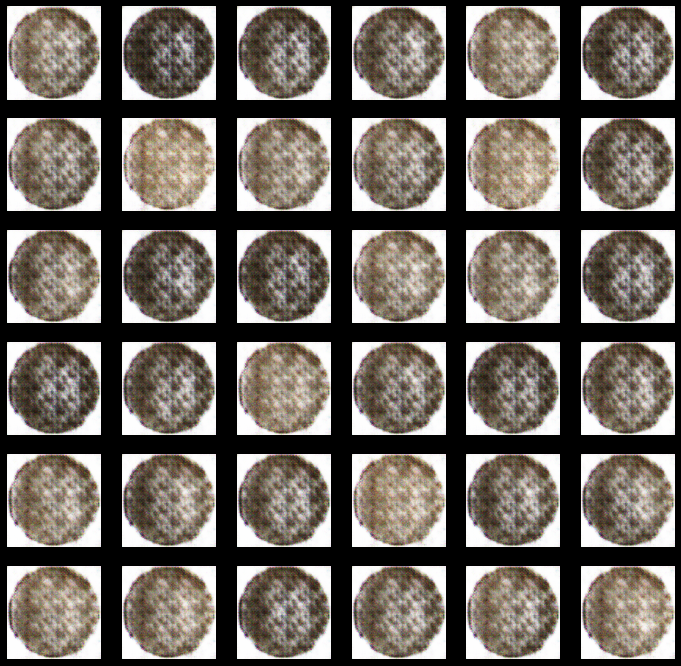

Generator Loss: -4.33 | Critic Loss: -39.817
Time for epoch 6: 58.24s
Remaining time: 15h 46m 56.28s


In [74]:
generator_losses, critic_losses = train(dataset, 1000)

Plot losses

In [ ]:
# plot generator loss
plt.plot(generator_losses)
plt.title('Generator Loss')
plt.xlabel('epoch')
plt.ylabel('generator loss')
plt.show()

# plot critic loss
plt.plot(critic_losses)
plt.title('critic Loss')
plt.xlabel('epoch')
plt.ylabel('critic loss')
plt.show()

Save generator

In [ ]:
mkdir('saved_generators/')
models.save_model(generator, f'saved_generators/{dataset_name}')

Generate images

Turn training progress into gif

In [ ]:
import glob
import imageio

skip = 10

with imageio.get_writer(f'gifs/{dataset_name}.gif', mode='I') as writer:
  filenames = sorted(glob.glob(f'output_images/{dataset_name}/image*.png'))
  for i in range(0, len(filenames), skip):
    writer.append_data(imageio.imread(filenames[i]))

# Results

Load generator

In [ ]:
generator = models.load(f'saved_generators/greek_coins')

Generate images

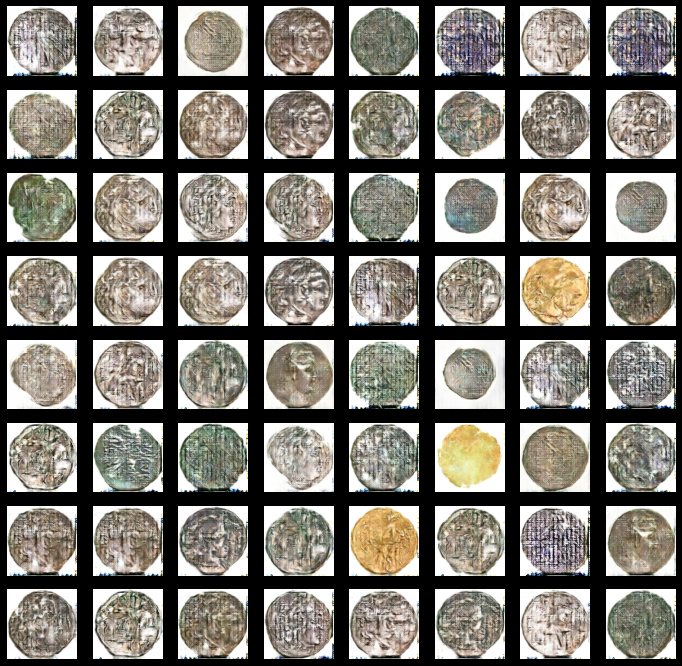

In [109]:
num_examples = 36
noise = tf.random.normal([num_examples, noise_dim])
generated = generator(noise)

fig = plt.figure(figsize=(12, 12))
for i in range(len(generated)):
  img = np.clip(generated[i] * 0.5 + 0.5, 0, 1)
  fig.add_subplot(6, 6, i + 1)
  plt.imshow(img)
  plt.axis('off')